In [1]:
import numpy as np
import pandas as pd
import os, subprocess, shutil
import matplotlib.pyplot as plt
import pyvista as pv
from myusefultools.parser import getVTKList
import xarray as xr

REPO_PATH = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')

caseName   = "constantHead"
solverFoam = "RichardsFoam"

PATH_TO_VTK = f"{caseName}/VTK"

## Check that solver is compiled
if not(solverFoam in subprocess.run(["which",f"{solverFoam}"],capture_output=True).stdout.decode('utf-8').strip()):
    print("######### SOLVER NOT FOUND ############")


In [2]:
def run_openfoam_model(hInit:np.float64, hTop:np.float64) -> None:

    ## Bring template for probes
    subprocess.run(f"cp {REPO_PATH}/misc/headTemplates/hConstant.tpl {caseName}/0.000/h".split())

    ## Replace placeholders in template
    subprocess.run(["sed", "-i", f"s/<<h_TOP_BOUNDARY>>/{hTop:.3E}/g", f"{caseName}/0.000/h"])
    subprocess.run(["sed", "-i", f"s/<<h_INITIAL_CONDITION>>/{hInit:.3E}/g", f"{caseName}/0.000/h"])

    ## Clean previous runs
    subprocess.run([f"foamListTimes", "-rm"], cwd=f"./{caseName}")

    ## Clean postprocessing
    postProc_path = f"{caseName}/postProcessing"
    if os.path.exists(postProc_path): shutil.rmtree(postProc_path)

    ## Run case
    subprocess.run([solverFoam], cwd=f"./{caseName}", stdout=subprocess.DEVNULL)

    ## Convert to VTK
    subprocess.run(["foamToVTK", "-noZero"], cwd=f"./{caseName}", stdout=subprocess.DEVNULL)

In [3]:
def get_mean_velocity() -> np.float64:

    ## Extract VTK results (this should be done with a probe but meh)
    all_vtk_paths = [os.path.join(PATH_TO_VTK, f) for f in getVTKList(PATH_TO_VTK)]
    last_vtk = all_vtk_paths[-1]
    mesh = pv.read(last_vtk)

    U = mesh['U']
    Uz = U[:,-1]
    meanU = np.average(Uz)
    #stdU = np.std(Uz)

    return meanU #(meanU, stdU)

In [4]:
def getAllMeshes(field:str):
    ## Extract VTK result (this should be done with a probe but meh)
    all_vtk_paths = [os.path.join(PATH_TO_VTK, f) for f in getVTKList(PATH_TO_VTK)]
    nTimes = len(all_vtk_paths)
    times = [float(t) for t in subprocess.check_output("foamListTimes", cwd=f"./{caseName}").decode("utf-8").split()]

    ## Use dimensions from the first VTK
    mesh = pv.read(all_vtk_paths[0])
    line = pv.Line(
        a:=[0, 0, mesh.bounds[5]],
        b:=[0, 0, mesh.bounds[2]])
    sample = mesh.sample_over_line(a,b)
    nPoints = len(sample[field])

    ## Initialize array to store data
    results = np.zeros([nPoints, nTimes])

    ## Extract field for each vtk field
    for t,vtk in enumerate(all_vtk_paths):
        mesh = pv.read(vtk)
        sample = mesh.sample_over_line(a,b)
        results[:,t] = sample[field]

    data = xr.DataArray(
        results, 
        dims=("z","t"), 
        coords={
            "z": sample.points[:,2], 
            "t": times})
 
    return data

In [5]:
## Careful with this gradient, might need a very fine mesh 
## to solve for such an abrupt change

hTop = -0.35
hInit = -0.69

run_openfoam_model(hTop=hTop, hInit=hInit)
θ = getAllMeshes("theta")

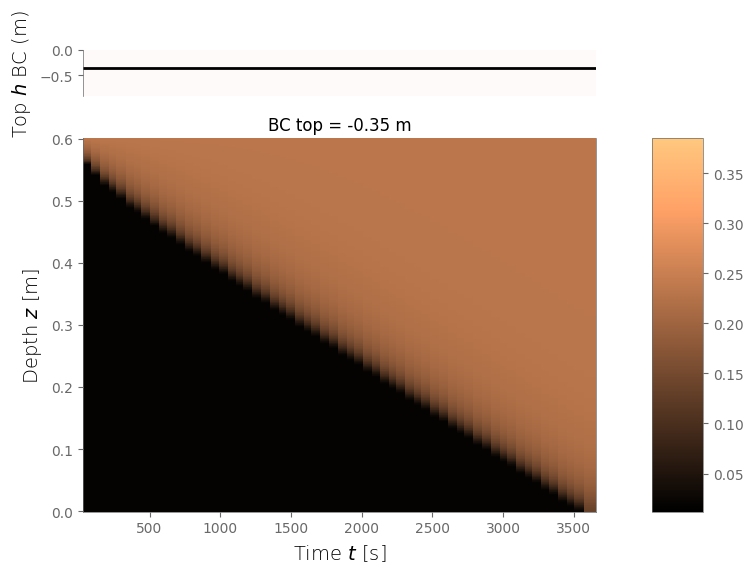

In [6]:
fig, axs = plt.subplots(2,2, figsize=[8,6], gridspec_kw={"height_ratios":[0.5,4], "width_ratios":[5,0.5]}, sharex=False)
fig.set_facecolor("#ffffff00")

axs[0,1].remove()

ax = axs[0,0]
ax.axhline(y=hTop)
ax.set(ylabel="Top $h$ BC (m)", xlabel="Time (s)", ylim=[-0.9,0], xlim=[0,3600])
ax.get_xaxis().set_visible(False)
ax.spines[["right","bottom"]].set_visible(False)

ax = axs[1,0]
img = ax.pcolormesh(θ.t,θ.z,θ, cmap="copper", vmin=0.012, vmax=0.385)
ax.set_xlabel("Time $t$ [s]")
ax.set_title(f"BC top = {hTop} m")
ax.set_ylabel("Depth $z$ [m]")
plt.colorbar(img, cax=axs[1,1])
plt.show()


In [7]:
hlist = [-0.25, -0.30, -0.35] #m
θlist = list()

for h in hlist:
    run_openfoam_model(hTop=h, hInit=-0.65)
    θlist.append(getAllMeshes("theta"))

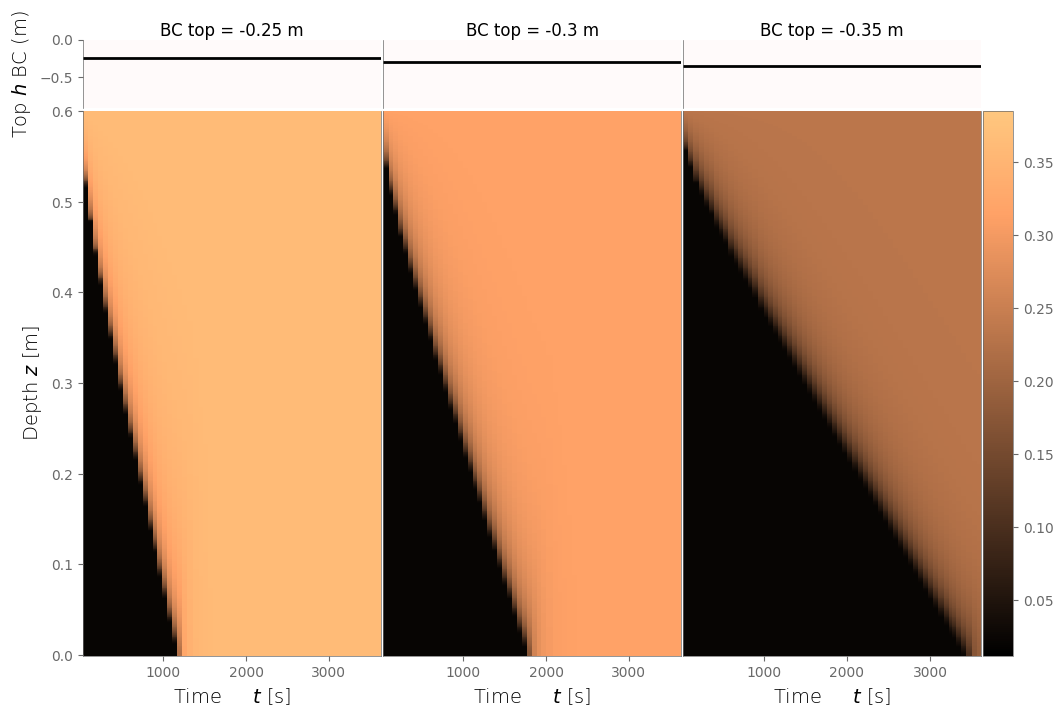

In [8]:
fig, axs = plt.subplots(2,4, sharey=False, sharex=False, figsize=[12,8], 
    gridspec_kw={"wspace":0.01, "hspace":0.01, "width_ratios":[1,1,1,0.1], "height_ratios":[0.5,4]})

fig.set_facecolor("#ffffff00")

for ax,h in zip(axs[0,:],hlist):
    ax.axhline(y=h)
    ax.set(ylim=[-0.9,0], xlim=[0,3600])
    ax.set_title(f"BC top = {h} m", pad=3)
    ax.set_xlim([0,3600])
    ax.get_xaxis().set_visible(False)
    ax.spines[["bottom","right"]].set_visible(False)

axs[0,-1].remove()
axs[0,0].set(ylabel="Top $h$ BC (m)", ylim=[-0.9,0])

for ax,θ,h in zip(axs[1,:],θlist,hlist):
    img = ax.pcolormesh(θ.t,θ.z, θ, vmin=0.012, vmax=0.385, cmap="copper")
    ax.set_xlabel("Time \t $t$ [s]")
    
for ax in axs[0,1:]: ax.get_yaxis().set_visible(False)
for ax in axs[1,1:-1]: ax.get_yaxis().set_visible(False)

axs[1,0].set_ylabel("Depth $z$ [m]")

plt.colorbar(img, cax=axs[1,-1])
plt.show()


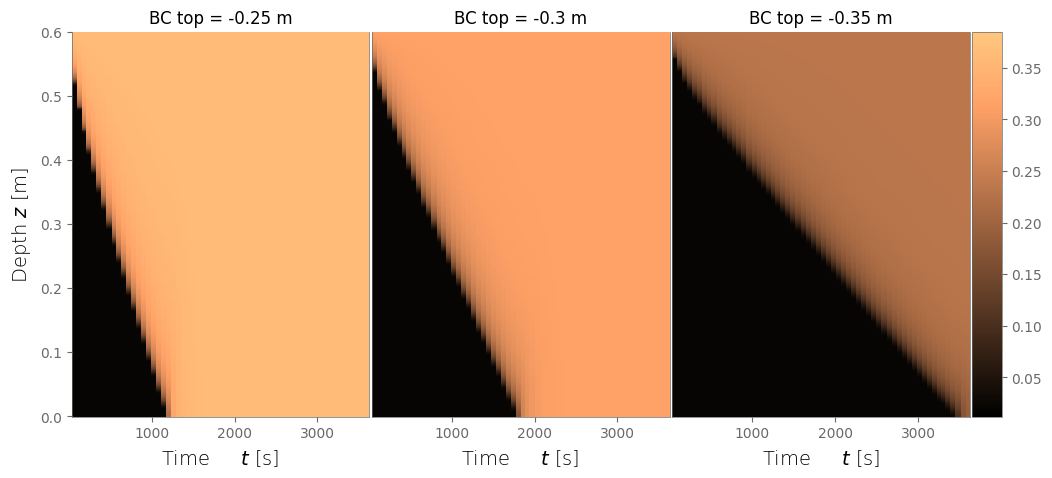

In [9]:


fig, axs = plt.subplots(1,4, sharey=False, figsize=[12,5], 
    gridspec_kw={"wspace":0.01, "width_ratios":[1,1,1,0.1]})

for ax,θ,h in zip(axs,θlist,hlist):
    img = ax.pcolormesh(θ.t,θ.z, θ, vmin=0.012, vmax=0.385, cmap="copper")
    ax.set_xlabel("Time \t $t$ [s]")
    ax.set_title(f"BC top = {h} m")
    
for ax in axs[1:-1]: ax.get_yaxis().set_visible(False)

axs[0].set_ylabel("Depth $z$ [m]")
plt.colorbar(img, cax=axs[-1])
fig.set_facecolor("#ffffff00")
plt.show()

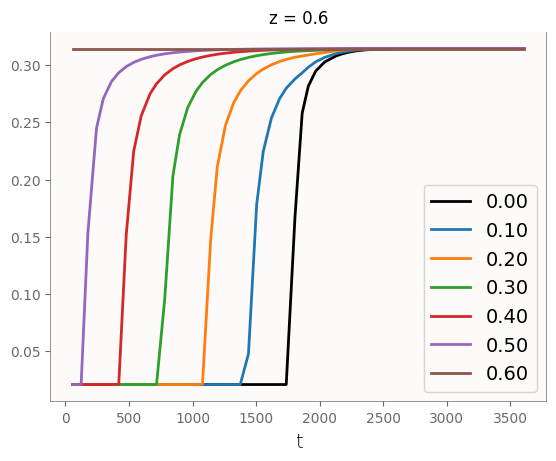

In [10]:
theta = θlist[1]
for z in np.arange(0.0,0.61,0.10):
    theta.sel(z=z).plot(label=f"{z:.2f}")
plt.legend()
plt.show()


In [11]:
# ## If we were using point probes (neh)

# postProc_path = f"{caseName}/postProcessing"
# postProc_clean = f"{caseName}/postProcessingClean"
# if os.path.exists(postProc_clean): shutil.rmtree(postProc_clean)
# shutil.copytree(postProc_path, postProc_clean)

# location_probes = f"{postProc_clean}/probes/0.000"

# for file in os.listdir(location_probes):
#     subprocess.run(["sed", "-i", r"s/\s\s\+/\t/g", file], cwd=location_probes)
#     subprocess.run(["sed", "-i", r"s/^\t//g", file], cwd=location_probes)
#     subprocess.run(["sed", "-i", r"/^#/d", file], cwd=location_probes)

# probe = "theta"
# results = pd.read_csv(os.path.join(location_probes,probe), sep="\t", names=["Time (s)"] + [f"θ{i}" for i in range(12)], index_col="Time (s)")
# results.tail()


# fig,ax = plt.subplots()
# for i in range(12):
#     ax.plot(results.index/86400, results[f'θ{i}'], label = f'θ{i}')
# ax.legend()
# ax.set_xlabel("Time [d]")
# ax.set_ylabel(probe)
# ax.set_xlim(0, 0.3)
# plt.show()